<a href="https://colab.research.google.com/github/debalina-chowdhury/Machine-Learning-in-90-days/blob/master/hurricane_net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
%cd gdrive/MyDrive/atlantic-hurricane-trajectory-prediction/docs

/content/gdrive/MyDrive/atlantic-hurricane-trajectory-prediction/docs


In [4]:
!ls

data  errors


In [5]:
%autosave 60

Autosaving every 60 seconds


In [6]:
# Import various libraries throughout the software
from pprint import pprint
from datetime import timedelta
from sklearn.preprocessing import RobustScaler
from geopy.distance import great_circle as vc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math as Math
import datetime
import dateutil
import io

In [7]:
# data cleaning/processing: (from hurricane-net, hammad)
db = []
with open('data/hurdat2-1851-2022-050423.txt') as raw: 
    for line in raw: 
        line = line.replace(' ', '').split(',')
    
        # Identify atlantic storm, first 2 letters should be AL
        if (line[0][:2] == 'AL') :
            storm_id = line[0]
            storm_name = line[1]
            storm_entries = line[2]

            # Iterate and read through best track entries
            for i in range(int(storm_entries)) :
                entry = raw.readline().replace(' ', '').split(',')
                # Filter -999 placeholder for missing central pressure
                entry = [None if x == "-999" else x for x in entry]
                # Construct date and time based on first two columns
                timestamp = datetime.datetime(int(entry[0][:4]), int(entry[0][4:6]), int(entry[0][6:8]), int(entry[1][:2]), int(entry[1][3:]))
                # Add entry into our current database
                db.append([storm_id, storm_name, timestamp] + entry[2:-1])
        else :
            print("Error, unidentified storm ".join(str(line[0])))

# Return DataFrame
dataset = pd.DataFrame(db, columns = ['storm_id', 'storm_name', 'entry_time', 'entry_id', 'entry_status', 'lat', 'long','max_wind', 'min_pressure', '34kt_ne', '34kt_se', '34kt_sw', '34kt_nw', '50kt_ne', '50kt_se', '50kt_sw', '50kt_nw', '64kt_ne', '64kt_se', '64kt_sw', '64kt_nw'])

In [8]:
models = dict()
class model :
  '''
  PURPOSE: To create a class for each model included in the forecast error database
  METHOD: Provide an API
  OUTOUT: A class with a DataFrame and associated operations
  '''
  name = None
  # Dictionary key: STMID
  storm = dict()
  def __init__(self, model_name) :
    self.name = model_name
    return

with open('errors/1970-present_OFCL_v_BCD5_ind_ATL_TI_errors_noTDs.txt') as raw :
    lines = raw.readlines()
    
    # Get model names and declare model objects
    line = lines[1].split()
    model_names = line[2:]
    for model_name in model_names :
        models[model_name] = model(model_name)
    
    # Data starts at line 9 
    for line in lines[9:] :
        line = line.split()
        # Identify atlantic storm date, storm id, associated sample sizes, latitude and longitude, and windspeed
        timestamp = datetime.datetime.strptime(line[0], "%d-%m-%Y/%H:%M:%S")
        storm_id = line[1]
        sample_sizes = {"F012": float(line[2]), "F024": float(line[3]),"F036": float(line[4]), "F048": float(line[5]), "F072": float(line[6]), "F096": float(line[7]), "F120": float(line[8]), "F144": float(line[9]), "F168": float(line[10])} 
        latitude = float(line[11])
        longitude = float(line[12])
        wind_speed = float(line[13])
    
                
        # Iterate through model forecast track and intensity errors 
        for i in range(len(model_names)) :
            intensity_forecast = dict(list(zip([timestamp, timestamp + timedelta(hours = 12), timestamp + timedelta(hours = 24), timestamp + timedelta(hours = 36), timestamp + timedelta(hours = 48), timestamp + timedelta(hours = 72), timestamp + timedelta(hours = 96), timestamp + timedelta(hours = 120), timestamp + timedelta(hours = 144), timestamp + timedelta(hours = 168)], [None if x == "-9999.0" else float(x) for x in line[14 + (20 * i) : 24 + (20 * i)]])))
            track_forecast = dict(list(zip([timestamp, timestamp + timedelta(hours = 12), timestamp + timedelta(hours = 24), timestamp + timedelta(hours = 36), timestamp + timedelta(hours = 48), timestamp + timedelta(hours = 72), timestamp + timedelta(hours = 96), timestamp + timedelta(hours = 120), timestamp + timedelta(hours = 144), timestamp + timedelta(hours = 168)], [None if x == "-9999.0" else float(x) for x in line[24 + (20 * i) : 34 + (20 * i)]])))
        
        # Add forecast to model and storm, initialize if storm id does not exist
        if storm_id not in models[model_names[i]].storm.keys() :
            models[model_names[i]].storm[storm_id] = dict()

        models[model_names[i]].storm[storm_id].update({
            timestamp : {
            "sample_sizes" : sample_sizes,
            "lat" : latitude,
            "long" : longitude,
            "wind_speed" : wind_speed,
            "intensity_forecast" : intensity_forecast,
            "track_forecast" : track_forecast,
            }
        })

In [9]:
# Show the first 3 OFCL hurricane model errors for Hurricane Katrina 2005 on 28-08-2005/18:00:00
pprint(models['OFCL'].storm['AL122005'][datetime.datetime(2005, 8, 28, 18, 0)], indent = 8)

{       'intensity_forecast': {       datetime.datetime(2005, 8, 28, 18, 0): None,
                                      datetime.datetime(2005, 8, 29, 6, 0): None,
                                      datetime.datetime(2005, 8, 29, 18, 0): None,
                                      datetime.datetime(2005, 8, 30, 6, 0): 0.0,
                                      datetime.datetime(2005, 8, 30, 18, 0): 20.9,
                                      datetime.datetime(2005, 8, 31, 18, 0): 93.6,
                                      datetime.datetime(2005, 9, 1, 18, 0): 170.2,
                                      datetime.datetime(2005, 9, 2, 18, 0): None,
                                      datetime.datetime(2005, 9, 3, 18, 0): None,
                                      datetime.datetime(2005, 9, 4, 18, 0): None},
        'lat': 0.0,
        'long': 26.3,
        'sample_sizes': {       'F012': 0.33,
                                'F024': 0.33,
                                'F036': 0

In [10]:
# Show the first 5 records from Hurricane Katrina 2005 (AL122005)
dataset.query('storm_id == "AL122005"').head()

storm_id storm_name          entry_time entry_id entry_status    lat  \
44681  AL122005    KATRINA 2005-08-23 18:00:00                    TD  23.1N   
44682  AL122005    KATRINA 2005-08-24 00:00:00                    TD  23.4N   
44683  AL122005    KATRINA 2005-08-24 06:00:00                    TD  23.8N   
44684  AL122005    KATRINA 2005-08-24 12:00:00                    TS  24.5N   
44685  AL122005    KATRINA 2005-08-24 18:00:00                    TS  25.4N   

        long max_wind min_pressure 34kt_ne  ... 34kt_sw 34kt_nw 50kt_ne  \
44681  75.1W       30         1008       0  ...       0       0       0   
44682  75.7W       30         1007       0  ...       0       0       0   
44683  76.2W       30         1007       0  ...       0       0       0   
44684  76.5W       35         1006      60  ...       0       0       0   
44685  76.9W       40         1003      60  ...       0       0       0   

      50kt_se 50kt_sw 50kt_nw 64kt_ne 64kt_se 64kt_sw 64kt_nw  
44681       0       0       0       0       0       0       0  
44682       0       0       0       0       0       0       0  
44683       0       0       0       0       0       0       0  
44684       0       0       0       0       0       0       0  
44685       0       0       0       0       0       0       0  

[5 rows x 21 columns]

# Transform Data
The following code will tranform the hurricane best path data into objects that can be better manipulated for processing. to match between datasets, we will also create a storm_id dictionary to store storm names matched with ID's

In [11]:
# Create hurricane class
class hurricane(object) : 
    def __init__(self, name, id) :
        # Set instance variables
        self.name = name
        self.id = id
        self.entries = dict()
        self.models = dict()
        
        return
    # Add 
    def add_entry(self, array) :
        entry = {
            array[0] : { # dateteime of entry
                'entry_time' : array[0], 
                'entry_id' : array[1],
                'entry_status' : array[2],
                'lat' : float(array[3][:-1]), # Convert to number from format '#.#N'
                'long' : float(array[4][:-1]), # Convert to number from format '#.#W'
                'max_wind' : float(array[5]),
                'min_pressure' : 980 if array[6] is None else float(array[6]), # Early records are -999 or None
                'wind_radii' :  array[7:], # Array based on HURDAT2 format
                'distance': 0,
                'direction': 0
            }
        }
        self.entries.update(entry)
        
        return
    # Add hurricane model errors
    def add_model(self, name, model) :
        self.models[name] = model
        
        return


    def update_dist_direc(self):
      t = pd.DataFrame(self.entries.values())
      dst = 0
      prev = (0,0)
      
      # For all latitude and longitude points of hurricane, calculate the angle of travel and distance
      for index,p in enumerate(zip(t['lat'], t['long'])):
          
          if prev == (0,0):
              prev = p
              continue 
          # Stores the distance into the DataFrame
          list(self.entries.values())[index]['distance'] = vc(prev,p).miles
          
          dLon = p[1] - prev[1];  
          temp = float(p[0]) # p[0] is a str?
          y_x = Math.sin(dLon) * Math.cos(temp);
          
          x_x = Math.cos(p[1]) * Math.sin(temp) - Math.sin(p[1]) * Math.cos(temp) * Math.cos(dLon);
          brng = Math.degrees(Math.atan2(y_x, x_x)) 
          if (brng < 0):
              brng+= 360;
          
          # Stores the angle of travel into the DataFrame
          list(self.entries.values())[index]['direction'] = brng
          # if self.id == 'AL122005' and index==2:
          if self.id == 'AL081994' and index==2:
            print(f'p[1]:{p[1]}')
            print(f'prev[1]:{prev[1]}')
            print(f'dLon:{dLon}')
            print(f'temp:{temp}')
            print(f'y_x:{y_x}')
            print(f'x_x:{x_x}')
            print(f'brng:{brng}')
          dst += vc(prev,p).miles
          prev = p

# Storm ID Key for matching between datasets
storm_ids = dict()
# Parse in hurricanes
hurricanes = dict()

print("Transforming HURDAT2 into objects . . .")
for index, entry in dataset.iterrows() :
    print("Transforming {}/{} entries from HURDAT2".format(index + 1, len(dataset)), end = "\r")
    # New hurricane
    if entry['storm_id'] not in hurricanes :
        hurricanes[entry['storm_id']] = hurricane(entry['storm_name'], entry['storm_id'])
        storm_ids[entry['storm_id']] = entry['storm_name']
    # Add entry to hurricane
    hurricanes[entry['storm_id']].add_entry(entry[2:])
print("\nDone!")

Transforming HURDAT2 into objects . . .
Transforming 53976/53976 entries from HURDAT2
Done!


# Load Data
The following will finalize our preliminary data preparation by loading some of the errors into each hurricane object. Note that models start from the year 1970 and any hurricane before that has no previous model data.

In [12]:
# Get all available model errors
# Load model errors into hurricanes
for id in storm_ids :
    for model in models :
        # Skip if this hurricane does not have the model
        if id not in models[model].storm :
            continue
        hurricanes[id].add_model(model, models[model].storm[id])
    hurricanes[id].update_dist_direc()

p[1]:85.9
prev[1]:85.1
dLon:0.8000000000000114
temp:16.5
y_x:-0.5038688074294795
x_x:-0.09353734284162374
brng:259.4834249123352


In [13]:
#will test distance and direction of the bulk update vs individual update
t=pd.DataFrame(hurricanes['AL081994'].entries.values())
t

entry_time entry_id entry_status   lat  long  max_wind  \
0 1994-09-24 12:00:00                    TD  16.0  84.5      25.0   
1 1994-09-24 18:00:00                    TD  16.3  85.1      30.0   
2 1994-09-25 00:00:00                    TD  16.5  85.9      30.0   
3 1994-09-25 06:00:00                    TD  16.6  86.7      30.0   
4 1994-09-25 12:00:00                    TD  16.7  87.6      30.0   
5 1994-09-25 18:00:00        L           TD  16.6  88.4      30.0   
6 1994-09-26 00:00:00                    TD  16.6  88.7      30.0   
7 1994-09-26 06:00:00                    TD  16.6  88.9      25.0   
8 1994-09-26 12:00:00                    TD  16.5  89.2      25.0   
9 1994-09-26 18:00:00                    TD  16.5  89.5      25.0   

   min_pressure                                         wind_radii   distance  \
0        1008.0  34kt_ne    None
34kt_se    None
34kt_sw    Non...   0.000000   
1        1007.0  34kt_ne    None
34kt_se    None
34kt_sw    Non...  44.891903   
2        1007.0  34kt_ne    None
34kt_se    None
34kt_sw    Non...  54.796781   
3        1006.0  34kt_ne    None
34kt_se    None
34kt_sw    Non...  53.433344   
4        1005.0  34kt_ne    None
34kt_se    None
34kt_sw    Non...  59.976134   
5        1004.0  34kt_ne    None
34kt_se    None
34kt_sw    Non...  53.406014   
6        1006.0  34kt_ne    None
34kt_se    None
34kt_sw    Non...  19.864134   
7        1007.0  34kt_ne    None
34kt_se    None
34kt_sw    Non...  13.242757   
8        1007.0  34kt_ne    None
34kt_se    None
34kt_sw    Non...  21.036343   
9        1007.0  34kt_ne    None
34kt_se    None
34kt_sw    Non...  19.874439   

    direction  
0    0.000000  
1  306.719439  
2  259.483425  
3  214.647871  
4  205.375417  
5  220.828574  
6  226.705956  
7  284.940686  
8  332.536353  
9  342.171773

In [14]:
t['dist']=0
t['direc']=0

In [15]:
#testing for one hurricane
prev=(0,0)
for index,p in enumerate(zip(t['lat'], t['long'])):
  if prev == (0,0):
    prev = p
    print(f'index:{index},prev:{prev}')
    continue 
  # Stores the distance into the DataFrame
  t.at[index,'dist'] = vc(prev,p).miles

  dLon = p[1] - prev[1];  
  temp = float(p[0]) # p[0] is a str?
  y_x = Math.sin(dLon) * Math.cos(temp);

  x_x = Math.cos(p[1]) * Math.sin(temp) - Math.sin(p[1]) * Math.cos(temp) * Math.cos(dLon);
  brng = Math.degrees(Math.atan2(y_x, x_x)) 
  if (brng < 0):
    brng+= 360;
  t.at[index,'direc'] = brng
  if index==2:
    print(f'p[1]:{p[1]}')
    print(f'prev[1]:{prev[1]}')
    print(f'dLon:{dLon}')
    print(f'temp:{temp}')
    print(f'y_x:{y_x}')
    print(f'x_x:{x_x}')
    print(f'brng:{brng}')
  print(index,t.at[index,'direc'])
  prev = p

index:0,prev:(16.0, 84.5)
1 306.71943856277255
p[1]:85.9
prev[1]:85.1
dLon:0.8000000000000114
temp:16.5
y_x:-0.5038688074294795
x_x:-0.09353734284162374
brng:259.4834249123352
2 259.4834249123352
3 214.6478709156233
4 205.37541693715318
5 220.82857383503298
6 226.7059563604921
7 284.9406861076747
8 332.53635339353264
9 342.17177270335054


In [16]:
t #to check that distance calculation and direction calculation from bulk vs individual

entry_time entry_id entry_status   lat  long  max_wind  \
0 1994-09-24 12:00:00                    TD  16.0  84.5      25.0   
1 1994-09-24 18:00:00                    TD  16.3  85.1      30.0   
2 1994-09-25 00:00:00                    TD  16.5  85.9      30.0   
3 1994-09-25 06:00:00                    TD  16.6  86.7      30.0   
4 1994-09-25 12:00:00                    TD  16.7  87.6      30.0   
5 1994-09-25 18:00:00        L           TD  16.6  88.4      30.0   
6 1994-09-26 00:00:00                    TD  16.6  88.7      30.0   
7 1994-09-26 06:00:00                    TD  16.6  88.9      25.0   
8 1994-09-26 12:00:00                    TD  16.5  89.2      25.0   
9 1994-09-26 18:00:00                    TD  16.5  89.5      25.0   

   min_pressure                                         wind_radii   distance  \
0        1008.0  34kt_ne    None
34kt_se    None
34kt_sw    Non...   0.000000   
1        1007.0  34kt_ne    None
34kt_se    None
34kt_sw    Non...  44.891903   
2        1007.0  34kt_ne    None
34kt_se    None
34kt_sw    Non...  54.796781   
3        1006.0  34kt_ne    None
34kt_se    None
34kt_sw    Non...  53.433344   
4        1005.0  34kt_ne    None
34kt_se    None
34kt_sw    Non...  59.976134   
5        1004.0  34kt_ne    None
34kt_se    None
34kt_sw    Non...  53.406014   
6        1006.0  34kt_ne    None
34kt_se    None
34kt_sw    Non...  19.864134   
7        1007.0  34kt_ne    None
34kt_se    None
34kt_sw    Non...  13.242757   
8        1007.0  34kt_ne    None
34kt_se    None
34kt_sw    Non...  21.036343   
9        1007.0  34kt_ne    None
34kt_se    None
34kt_sw    Non...  19.874439   

    direction       dist       direc  
0    0.000000   0.000000    0.000000  
1  306.719439  44.891903  306.719439  
2  259.483425  54.796781  259.483425  
3  214.647871  53.433344  214.647871  
4  205.375417  59.976134  205.375417  
5  220.828574  53.406014  220.828574  
6  226.705956  19.864134  226.705956  
7  284.940686  13.242757  284.940686  
8  332.536353  21.036343  332.536353  
9  342.171773  19.874439  342.171773

In [17]:
models.keys()

dict_keys(['OFCL', 'BCD5'])

# Feature Engineering & Data Augmentation
The following section will extract the relevant features and engineer each data point so that we can fit it into the model. Because the type of inputs are important, the features will be transformed based on the model architecture. This will also include data augmentation methods. The higher level architecture will be a deep learning recurrent neural network with LSTM and time distributed layers.

The current statistical baseline model using multivariate regression uses multiple predictors as input. According to Knaff 2013, the following predictors were calculated for their intensity model that were not included in the HURDAT2 database. These features can be calculated from the data loaded into our current object model.
1. Date Information
2. Zonal Speed Of The Storm (U) (kt)
3. Meridional Speed Of The Storm (V) (kt)
4. 12-h Change In Intensity (DVMX) (kt)

The shape on the input to the LSTM will be in a 3D array with the format [samples, timestamps, features]. We will intitially begin with 1 time step and evaluate more can benefit our model. The output requires a 5 day forecast and observations without track data 5 days in the future will not be used.

In [23]:
def feature_extraction(timestep, previous) :
    '''
    PURPOSE: Calculate the features for a machine learning model within the context of hurricane-net
    METHOD: Use the predictors and the calculation methodology defined in Knaff 2013
    INPUT:  timestep - current dictionary of features in the hurricane object format
            previous - previous timestep dictionary of features in the hurricane object format
    OUTPUT: Dictionary of features
    
    timestep = {
      'lat' : float,
      'long' : float,
      'max-wind' : float,
      'entry-time' : datetime
    }
    '''
    features = {
        'lat' : timestep['lat'],
        'long' : timestep['long'],
        'max_wind' : timestep['max_wind'],
        'delta_wind' : (timestep['max_wind'] - previous['max_wind']) / # Calculated from track (12h)
            ((timestep['entry_time'] - previous['entry_time']).total_seconds() / 43200),
        'min_pressure' : timestep['min_pressure'], 
        'zonal_speed' : (timestep['lat'] - previous['lat'])/ # Calculated from track (per hour)
            ((timestep['entry_time'] - previous['entry_time']).total_seconds() / 3600),
        'meridonal_speed' : (timestep['long'] - previous['long'])/# Calculated from track (per hour)
            ((timestep['entry_time'] - previous['entry_time']).total_seconds() / 3600),
        'year' : timestep['entry_time'].year,
        'month' : timestep['entry_time'].month,
        'day' : timestep['entry_time'].day,
        'hour' : timestep['entry_time'].hour,
        'delta_pressure': (timestep['min_pressure'] - previous['min_pressure']) /
            ((timestep['entry_time'] - previous['entry_time']).total_seconds() / 43200),
        'distance': timestep['distance'],
        'direction': timestep['direction']
    }
    return features

def extract_test_dataset(features):
    df = pd.DataFrame(features)
    df_test = df[df['year']==2022]
    df_train_val = df[df['year']!=2022]
    
def storm_x_y(storm, timesteps = 1, lag = 24) :
    '''
    PURPOSE: Create independent and dependent samples for a machine learning model based on the timesteps
    METHOD: Use the HURDAT2 database and a hurricane object as defined in hurricane-net for feature extraction
    INPUT:  storm - hurricane object
            timesteps - (default = 1) number of timesteps to calculate
            include_none - (default = False) Boolean for including None in test data. Imputing function unavailable.
            lag - (default = 24) lag in hours for the dependent variables up to 5 days
    OUTPUT: Dictionary with independent (x) and dependent (y) values.
    '''
    x = []
    x_test = []
    # Create testing data structure with a dictionary
    times = [time * lag for time in range(1, (120 // lag) + 1)] # Begin at lag hours with lag increments up to 120h inclusive
    y = dict([(time,[]) for time in times])
    y_test = dict([(time,[]) for time in times])
    # Sort by entry time
    entries = [entry[1] for entry in sorted(storm.entries.items())]
    
    for index in range(len(entries)) :
        if index < timesteps : # Flag for insufficient initial time steps
            continue

        # If we're not including None values, check to see if there will be any
        if None in [storm.entries.get(entries[index]['entry_time'] +
                                         datetime.timedelta(hours = future)) for future in times] : break
            
        # Calculate time steps and their features for independent values
        sample = []
        test_sample = []
        for step in range(timesteps) :
            # Training sample
            timestep = entries[index - step]
            previous = entries[index - step - 1]
            if feature_extraction(timestep, previous)['year']==2022:
              test_sample.append([timestep['entry_time']] + [[feature_extraction(timestep, previous)]])
            else:
              sample.append([timestep['entry_time']] + [[feature_extraction(timestep, previous)]])
            # print('sample')
            # print(sample)
        x.append(sample) # Add our constructed sample
        x_test.append(test_sample)
        
        # Calculate time steps and their features for dependent values
        for future in times :
            timestep = storm.entries.get(entries[index]['entry_time'] + datetime.timedelta(hours = future))
            previous = storm.entries.get(entries[index]['entry_time'] + datetime.timedelta(hours = future - lag))
            
            if feature_extraction(timestep, previous)['year']==2022:
              if timestep and previous: 
                y_test[future].append(feature_extraction(timestep, previous))
              else: 
                y_test[future].append(None)
            else:
              if timestep and previous:
                y[future].append(feature_extraction(timestep, previous))
              else :
                y[future].append(None)
    
    # Return output, if there is no output, return None.
    if len(x) == 0 :
        return None
    else:
        # print(f'x:{x}')
        return {'x': x, 'x_test': x_test, 'y': y, 'y_test': y_test}
def shape(hurricanes, timesteps, remove_missing = True) :
    '''
    PURPOSE: Shape our data for input into machine learning models
    METHOD: Use a numpy array to shape into (samples, timesteps, features)
    INPUT:  hurricanes - dictionary of hurricane objects
            timesteps - number of timesteps for the shape
            remove_missing - boolean indicating whether the algorithm will disregard missing values
    OUTPUT: numpy array of shape (samples, timesteps, 11) where 11 is the number of predictors in a hurricane object
    '''
    x = []
    x_test = []
    y = []
    y_test = []
    lag = 24 # lag time in hours
    precision = np.float64 # defines the precision of our data type
    times = [time * lag for time in range(1, (120 // lag) + 1)] # Begin at lag hours with lag increments up to 120h inclusive
    count = 0
    for hurricane in hurricanes.values() :
        count += 1
        result = storm_x_y(hurricane, timesteps, lag)
        # print('result')
        # print(result)
        if result is None :
            continue
        # Extract only the values from the strom features using our specified precision
        hurricane_x = np.array(
            [[list(sample[1][0].values()) for sample in x] for x in result['x']],
            dtype = precision)
        # if count==10:
          # print(f'hurricane_x:{hurricane_x}')
        hurricane_y = np.array(
            [[list(result['y'][time][index].values()) for time in times] for index in range(len(result['y'][lag]))],
            dtype = precision)
        hurricane_x_test = np.array(
            [[list(sample[1][0].values()) for sample in x] for x in result['x_test']],
            dtype = precision)
        # if count==10:
          # print(f'hurricane_x:{hurricane_x}')
        hurricane_y_test = np.array(
            [[list(result['y_test'][time][index].values()) for time in times] for index in range(len(result['y_test'][lag]))],
            dtype = precision)
        # Disregard if algorithm requires no missing values
        if remove_missing :
            if (len(np.where(np.isnan(hurricane_x))[0]) > 0) or (len(np.where(np.isnan(hurricane_y))[0]) > 0) :
                continue
        # Add to our results
        x.extend(hurricane_x)
        y.extend(hurricane_y)
        x_test.extend(hurricane_x_test)
        y_test.extend(hurricane_y_test)
        print("Feature engineered {}/{} hurricanes for {} timestep(s)".format(count, len(hurricanes), timesteps), end = "\r")
    print("\nDone feature engineering hurricanes.")
    # print(x)
    return {'x': np.array(x), 'y': np.array(y), 'x_test': np.array(x_test), 'y_test': np.array(y_test)}
def scaler(processed_data, hurricanes) :
    '''
    PURPOSE: Scale our data using the RobustScaler method from the sklearn library
    METHOD: Generate data using 1 timesteps and then remove the NaN or None types to use the scaler methods
    INPUT:  hurricanes - dictionary of hurricane objects
            processed_data - dictionary of x and y values of data produced by shape() function with no missing values
    OUTPUT: 1) Scaled processed_data using RobustScaler
            2) RobustScaler object fit with appropriate data
    '''
    print("Scaling Data . . . (1 timestep for unqiue data)")
    # Create our scaler
    unqiue_data = shape(hurricanes, timesteps = 1)
    x = np.reshape(unqiue_data['x'], (unqiue_data['x'].shape[0], -1))
    x = np.delete(x, np.where(np.isnan(x))[0], 0)
    x_test = np.reshape(unqiue_data['x_test'], (unqiue_data['x_test'].shape[0], -1))
    x_test = np.delete(x_test, np.where(np.isnan(x_test))[0], 0)
    scaler = RobustScaler()
    scaler.fit(x)
    scaler.fit(x_test)
    # Scale our data
    for index in range(len(processed_data['x'])) :
        # Scale our x
        processed_data['x'][index] = scaler.transform(processed_data['x'][index])
        # Scale our y
        processed_data['y'][index] = scaler.transform(processed_data['y'][index])
        # Scale our x_test
        processed_data['x_test'][index] = scaler.transform(processed_data['x_test'][index])
        # Scale our y_test
        processed_data['y_test'][index] = scaler.transform(processed_data['y_test'][index])
    print("Done scaling.")
    return processed_data, scaler
# Finalize and scale procesed data into a dictionary
preprocessed_data = shape(hurricanes, timesteps = 5)
processed_data, scaler = scaler(preprocessed_data, hurricanes)

Streaming output truncated to the last 5000 lines.
[[Timestamp('1856-08-29 18:00:00'), [{'lat': 24.9, 'long': 86.8, 'max_wind': 90.0, 'delta_wind': 0.0, 'min_pressure': 980, 'zonal_speed': 0.033333333333333215, 'meridonal_speed': 0.06666666666666525, 'year': 1856, 'month': 8, 'day': 29, 'hour': 18, 'delta_pressure': 0.0, 'distance': 28.6424759563674, 'direction': 27.36297647925518}]], [Timestamp('1856-08-29 12:00:00'), [{'lat': 24.7, 'long': 86.4, 'max_wind': 90.0, 'delta_wind': 0.0, 'min_pressure': 980, 'zonal_speed': 0.08333333333333333, 'meridonal_speed': 0.13333333333333522, 'year': 1856, 'month': 8, 'day': 29, 'hour': 12, 'delta_pressure': 0.0, 'distance': 61.03547021294364, 'direction': 45.95516616275008}]], [Timestamp('1856-08-29 06:00:00'), [{'lat': 24.2, 'long': 85.6, 'max_wind': 90.0, 'delta_wind': 0.0, 'min_pressure': 980, 'zonal_speed': 0.05000000000000012, 'meridonal_speed': 0.08333333333333333, 'year': 1856, 'month': 8, 'day': 29, 'hour': 6, 'delta_pressure': 0.0, 'distan

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Streaming output truncated to the last 5000 lines.
[[Timestamp('1885-08-23 18:00:00'), [{'lat': 25.1, 'long': 79.1, 'max_wind': 60.0, 'delta_wind': 0.0, 'min_pressure': 980, 'zonal_speed': 0.15000000000000036, 'meridonal_speed': 0.08333333333333333, 'year': 1885, 'month': 8, 'day': 23, 'hour': 18, 'delta_pressure': 0.0, 'distance': 69.66128658682122, 'direction': 44.13970865098664}]], [Timestamp('1885-08-23 12:00:00'), [{'lat': 24.2, 'long': 78.6, 'max_wind': 60.0, 'delta_wind': 0.0, 'min_pressure': 980, 'zonal_speed': 0.11666666666666654, 'meridonal_speed': 0.09999999999999905, 'year': 1885, 'month': 8, 'day': 23, 'hour': 12, 'delta_pressure': 0.0, 'distance': 61.45570940310911, 'direction': 22.02518967840346}]]]
sample
[[Timestamp('1885-08-23 18:00:00'), [{'lat': 25.1, 'long': 79.1, 'max_wind': 60.0, 'delta_wind': 0.0, 'min_pressure': 980, 'zonal_speed': 0.15000000000000036, 'meridonal_speed': 0.08333333333333333, 'year': 1885, 'month': 8, 'day': 23, 'hour': 18, 'delta_pressure': 0.0

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)




[[Timestamp('1894-09-19 18:00:00'), [{'lat': 14.1, 'long': 56.3, 'max_wind': 80.0, 'delta_wind': 20.0, 'min_pressure': 980, 'zonal_speed': 0.016666666666666607, 'meridonal_speed': 0.13333333333333286, 'year': 1894, 'month': 9, 'day': 19, 'hour': 18, 'delta_pressure': 0.0, 'distance': 54.06443647137018, 'direction': 1.5661260636052456}]], [Timestamp('1894-09-19 12:00:00'), [{'lat': 14.0, 'long': 55.5, 'max_wind': 70.0, 'delta_wind': 10.0, 'min_pressure': 980, 'zonal_speed': 0.016666666666666607, 'meridonal_speed': 0.16666666666666666, 'year': 1894, 'month': 9, 'day': 19, 'hour': 12, 'delta_pressure': 0.0, 'distance': 67.41057979254816, 'direction': 11.64959649612631}]], [Timestamp('1894-09-19 06:00:00'), [{'lat': 13.9, 'long': 54.5, 'max_wind': 65.0, 'delta_wind': 20.0, 'min_pressure': 980, 'zonal_speed': 0.03333333333333351, 'meridonal_speed': 0.16666666666666666, 'year': 1894, 'month': 9, 'day': 19, 'hour': 6, 'delta_pressure': 0.0, 'distance': 68.50707002984097, 'direction': 149.399

KeyboardInterrupt: ignored

# Model Architecture
Following feature engineering, we are now ready to input our data into a machine learning algorithm. The scope of this project will attempt a deep learning approach to forecasting Atlantic tropical cyclones. We will experiment with nunermous different architectures but we will focus around a Recurrent Neural Network utilizing LSTM cells.

Notes:

1.   We will use 500 epochs for wind intensity because the validation loss is not decreasing
2.   We will use 1,000 epochs for latitute and longitude

In [18]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import Bidirectional
from keras.layers import RepeatVector
from sklearn import model_selection

# Create our cross validation data structure
X_train, X_val, y_train, y_val = model_selection.train_test_split(processed_data['x'], processed_data['y'],
                                                                    test_size = 0.2)

In [30]:
def bd_lstm_rmsprop(X_train, y_train, X_test, y_test, n_epochs = 500) :    
    model = Sequential()
    model.add(Bidirectional(LSTM(units = 512, return_sequences = True, dropout = 0.1),
                            input_shape = (X_train.shape[1],X_train.shape[2])))
    # model.add(Bidirectional(LSTM(units = 512, return_sequences = True, dropout = 0.1)))
    model.add(LSTM(units = 256, return_sequences = True, dropout = 0.1))
    # model.add(TimeDistributed(Dense(1)))
    model.add(TimeDistributed(Dense(1)))
    model.compile(loss='mse', optimizer='rmsprop')
    print(model.summary())
    history = model.fit(X_train, y_train, batch_size = len(X_train), epochs = n_epochs,
                        validation_data = (X_test, y_test))
    return model, history

In [32]:
def bd_lstm_rmsprop(X_train, y_train, X_test, y_test, n_epochs = 500) :    
    model = Sequential()
    model.add(Bidirectional(LSTM(units = 512, return_sequences = True, dropout = 0.05),
                            input_shape = (X_train.shape[1],X_train.shape[2])))
    model.add(LSTM(units = 256, return_sequences = True, dropout = 0.05))
    model.add(TimeDistributed(Dense(1)))
    model.compile(loss='mse', optimizer='rmsprop')
    print(model.summary())
    history = model.fit(X_train, y_train, batch_size = len(X_train), epochs = n_epochs,
                        validation_data = (X_test, y_test))
    return model, history

In [22]:
def bd_lstm_td(X_train, y_train, X_test, y_test, n_epochs = 500) :    
    model = Sequential()
    model.add(Bidirectional(LSTM(units = 512, return_sequences = True, dropout = 0.05),
                            input_shape = (X_train.shape[1],X_train.shape[2])))
    model.add(LSTM(units = 256, return_sequences = True, dropout = 0.05))
    model.add(TimeDistributed(Dense(1)))
    model.compile(loss='mse', optimizer='adadelta')
    print(model.summary())
    history = model.fit(X_train, y_train, batch_size = len(X_train), epochs = n_epochs,
                        validation_data = (X_test, y_test))
    return model, history

In [20]:
# Train for wind intensity
y_train_wind = np.array([[[features[2]] for features in y] for y in y_train], dtype = np.float64)
y_test_wind = np.array([[[features[2]] for features in y] for y in y_test], dtype = np.float64)

# Train for latitude and longitude location
y_train_lat = np.array([[[features[0]] for features in y] for y in y_train], dtype = np.float64)
y_test_lat = np.array([[[features[0]] for features in y] for y in y_test], dtype = np.float64)
y_train_long = np.array([[[features[1]] for features in y] for y in y_train], dtype = np.float64)
y_test_long = np.array([[[features[1]] for features in y] for y in y_test], dtype = np.float64)

# Train for min pressure
y_train_pressure = np.array([[[features[4]] for features in y] for y in y_train], dtype = np.float64)
y_test_pressure = np.array([[[features[4]] for features in y] for y in y_test], dtype = np.float64)

# Train for direction
y_train_direction = np.array([[[features[13]] for features in y] for y in y_train], dtype = np.float64)
y_test_direction = np.array([[[features[13]] for features in y] for y in y_test], dtype = np.float64)


# Train for distance
y_train_distance = np.array([[[features[12]] for features in y] for y in y_train], dtype = np.float64)
y_test_distance = np.array([[[features[12]] for features in y] for y in y_test], dtype = np.float64)

In [31]:
model_wind_rmsprop, model_wind_history_rmsprop = bd_lstm_rmsprop(X_train, y_train_wind, X_test, y_test_wind, n_epochs = 500)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_7 (Bidirectio  (None, 5, 1024)          2158592   
 nal)                                                            
                                                                 
 lstm_12 (LSTM)              (None, 5, 256)            1311744   
                                                                 
 time_distributed_7 (TimeDis  (None, 5, 1)             257       
 tributed)                                                       
                                                                 
Total params: 3,470,593
Trainable params: 3,470,593
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/500
1/1 [==============================] - 8s 8s/step - loss: 0.6518 - val_loss: 1.3411
Epoch 2/500
1/1 [==============================] - 0s 424ms/step - loss: 1.

KeyboardInterrupt: ignored

In [21]:
model_wind_sgd, model_wind_history_sgd = bd_lstm_sgd(X_train, y_train_wind, X_test, y_test_wind, n_epochs = 500)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 5, 1024)          2158592   
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 5, 1024)          6295552   
 nal)                                                            
                                                                 
 lstm_2 (LSTM)               (None, 5, 256)            1311744   
                                                                 
 time_distributed (TimeDistr  (None, 5, 1)             257       
 ibuted)                                                         
                                                                 
Total params: 9,766,145
Trainable params: 9,766,145
Non-trainable params: 0
______________________________________________

In [ ]:
model_wind, model_wind_history = bd_lstm_td(X_train, y_train_wind, X_test, y_test_wind, n_epochs = 500)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_3 (Bidirectio  (None, 5, 1024)          2158592   
 nal)                                                            
                                                                 
 lstm_7 (LSTM)               (None, 5, 256)            1311744   
                                                                 
 time_distributed_3 (TimeDis  (None, 5, 1)             257       
 tributed)                                                       
                                                                 
Total params: 3,470,593
Trainable params: 3,470,593
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/500
1/1 [==============================] - 8s 8s/step - loss: 0.6493 - val_loss: 0.6631
Epoch 2/500
1/1 [==============================] - 0s 452ms/step - loss: 0.

In [33]:
model_wind_rmsprop, model_wind_history_rmsprop = bd_lstm_rmsprop(X_train, y_train_wind, X_test, y_test_wind, n_epochs = 500)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_8 (Bidirectio  (None, 5, 1024)          2158592   
 nal)                                                            
                                                                 
 lstm_14 (LSTM)              (None, 5, 256)            1311744   
                                                                 
 time_distributed_8 (TimeDis  (None, 5, 1)             257       
 tributed)                                                       
                                                                 
Total params: 3,470,593
Trainable params: 3,470,593
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/500
1/1 [==============================] - 8s 8s/step - loss: 0.6247 - val_loss: 1.0751
Epoch 2/500
1/1 [==============================] - 0s 417ms/step - loss: 1.

In [38]:
model_lat, model_lat_history = bd_lstm_rmsprop(X_train, y_train_lat, X_test, y_test_lat, n_epochs = 1000)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_9 (Bidirectio  (None, 5, 1024)          2158592   
 nal)                                                            
                                                                 
 lstm_16 (LSTM)              (None, 5, 256)            1311744   
                                                                 
 time_distributed_9 (TimeDis  (None, 5, 1)             257       
 tributed)                                                       
                                                                 
Total params: 3,470,593
Trainable params: 3,470,593
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/1000
1/1 [==============================] - 7s 7s/step - loss: 1.3182 - val_loss: 1.1183
Epoch 2/1000
1/1 [==============================] - 0s 487ms/step - loss: 

In [ ]:
model_long, model_long_history = bd_lstm_td(X_train, y_train_long, X_test, y_test_long, n_epochs = 1000)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_1 (Bidirectio  (None, 5, 1024)          2158592   
 nal)                                                            
                                                                 
 lstm_3 (LSTM)               (None, 5, 256)            1311744   
                                                                 
 time_distributed_1 (TimeDis  (None, 5, 1)             257       
 tributed)                                                       
                                                                 
Total params: 3,470,593
Trainable params: 3,470,593
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/1000
1/1 [==============================] - 8s 8s/step - loss: 0.5016 - val_loss: 0.5195
Epoch 2/1000
1/1 [==============================] - 0s 451ms/step - loss: 

In [ ]:
model_pressure, model_pressure_history = bd_lstm_td(X_train, y_train_pressure, X_test, y_test_pressure, n_epochs = 500)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_2 (Bidirectio  (None, 5, 1024)          2158592   
 nal)                                                            
                                                                 
 lstm_5 (LSTM)               (None, 5, 256)            1311744   
                                                                 
 time_distributed_2 (TimeDis  (None, 5, 1)             257       
 tributed)                                                       
                                                                 
Total params: 3,470,593
Trainable params: 3,470,593
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/500
1/1 [==============================] - 14s 14s/step - loss: 0.9745 - val_loss: 1.0242
Epoch 2/500
1/1 [==============================] - 0s 432ms/step - loss: 

In [36]:
def ai_errors(predictions, observations, history = None) :
    '''
    PURPOSE: Provide descriptive statistics on the predicted output versus the observed measurments
    METHOD:  Take the errors of the predictions and answers and then calculate standard descriptive statistics
    INPUT:   predictions - 2D array of predictions of observed output
             observations - 2D array measurements of observed output
             history - Keras history model for displaying model loss, default is None if not available
    OUTPUT:
    '''
    errors = []
    for i in range(len(predictions)) :
        for j in range(len(predictions[i])) :
            # Calculate errors
            error = predictions[i][j] - observations[i][j]
            errors.append(error)
    
    # Display history and erros
    plt.figure(1)
    plt.hist(errors, bins = 50)
    plt.title('error histogram')
    plt.xlabel('error')
    plt.ylabel('frequency')
    plt.grid(True)
    
    plt.figure(2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
    return pd.DataFrame(errors)

In [34]:
# Predict values
wind_predictions = model_wind_rmsprop.predict(X_test)
# lat_predictions = model_lat.predict(X_test)
# long_predictions = model_long.predict(X_test)
# pressure_predictions = model_pressure.predict(X_test)
# # Scale back our predictions
# # Wind
wind_predictions_scaled = [scaler.inverse_transform([[0,0,winds[0],0,0,0,0,0,0,0,0,0,0,0] for winds in prediction])
                           for prediction in wind_predictions]
y_wind_test_scaled = [scaler.inverse_transform([[0,0,winds[0],0,0,0,0,0,0,0,0,0,0,0] for winds in observation])
                      for observation in y_test_wind]
# # Latitude
# lat_predictions_scaled = [scaler.inverse_transform([[lat[0],0,0,0,0,0,0,0,0,0,0,0,0,0] for lat in prediction])
#                           for prediction in lat_predictions]
# y_lat_test_scaled = [scaler.inverse_transform([[lat[0],0,0,0,0,0,0,0,0,0,0,0,0,0] for lat in observation])
#                      for observation in y_test_lat]
# # Longitude
# long_predictions_scaled = [scaler.inverse_transform([[0,long[0],0,0,0,0,0,0,0,0,0,0,0,0] for long in prediction])
#                            for prediction in long_predictions]
# y_long_test_scaled = [scaler.inverse_transform([[0,long[0],0,0,0,0,0,0,0,0,0,0,0,0] for long in observation])
#                       for observation in y_test_long]

# # Wind
# pressure_predictions_scaled = [scaler.inverse_transform([[0,0,0,0,pressure[0],0,0,0,0,0,0,0,0,0] for pressure in prediction])
#                            for prediction in pressure_predictions]
# y_pressure_test_scaled = [scaler.inverse_transform([[0,0,0,0,pressure[0],0,0,0,0,0,0,0,0,0] for pressure in observation])
#                       for observation in y_test_pressure]

83/83 [==============================] - 1s 3ms/step


Wind


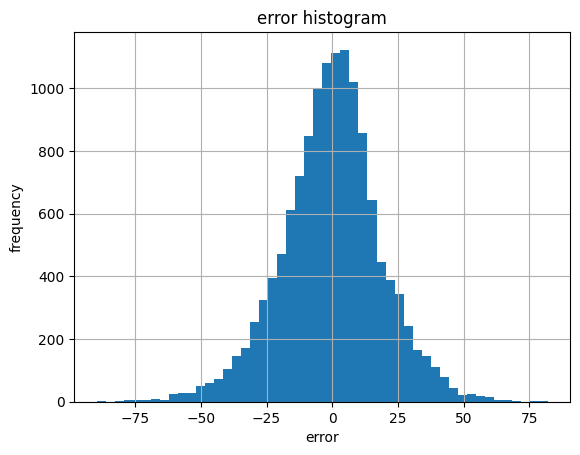

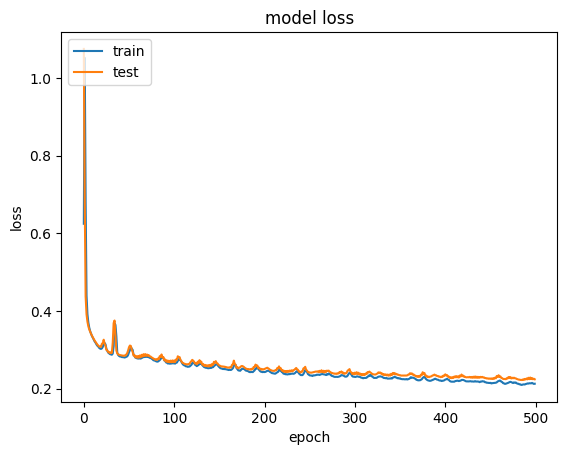

0
count  13245.000000
mean      -0.379890
std       18.930520
min      -89.506288
25%      -11.460466
50%        0.284307
75%       10.971974
max       82.038913

In [37]:
# Record wind predictions and observations
print("Wind")
wind_predictions = [[pred[2] for pred in hurricanes_pred] for hurricanes_pred in wind_predictions_scaled]
wind_observations = [[obsrv[2] for obsrv in hurricanes_obsrv] for hurricanes_obsrv in y_wind_test_scaled]

# Present Errors
ai_errors(wind_predictions, wind_observations, model_wind_history_rmsprop).describe()

Lat


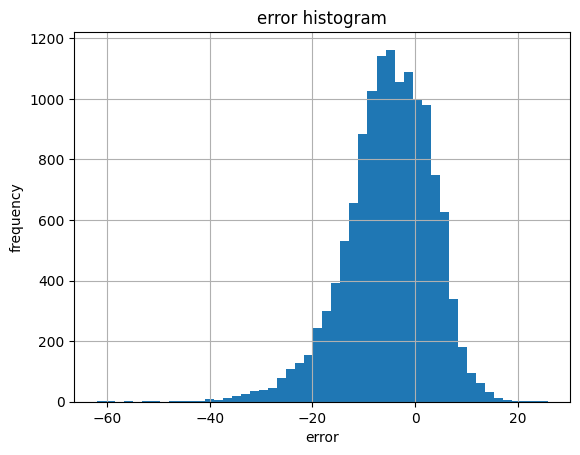

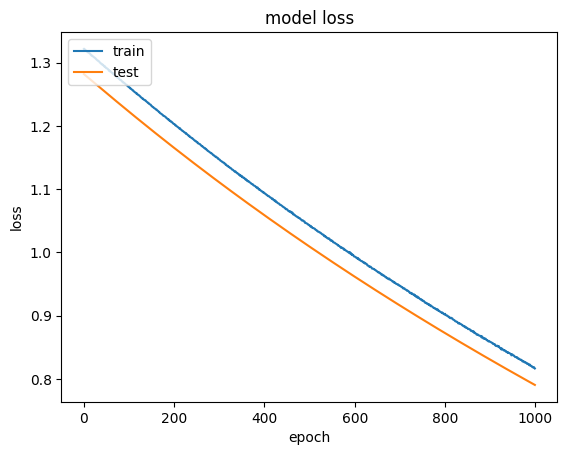

0
count  13245.000000
mean      -5.172417
std        8.508202
min      -61.964311
25%       -9.958999
50%       -4.605626
75%        0.848776
max       25.861966

In [ ]:
print("Lat")
lat_predictions = [[pred[0] for pred in hurricanes_pred] for hurricanes_pred in lat_predictions_scaled]
lat_observations = [[obsrv[0] for obsrv in hurricanes_obsrv] for hurricanes_obsrv in y_lat_test_scaled]
ai_errors(lat_predictions, lat_observations, model_lat_history).describe()

Long


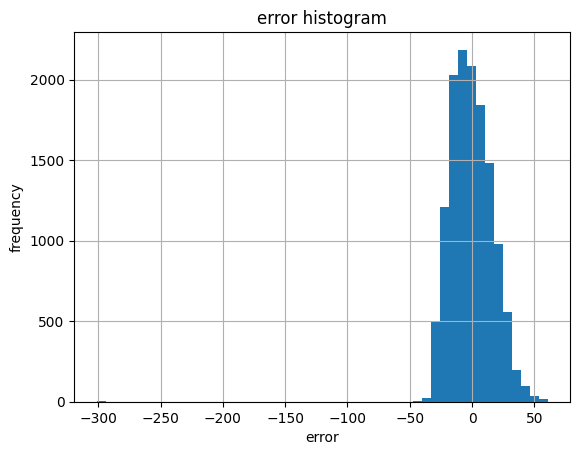

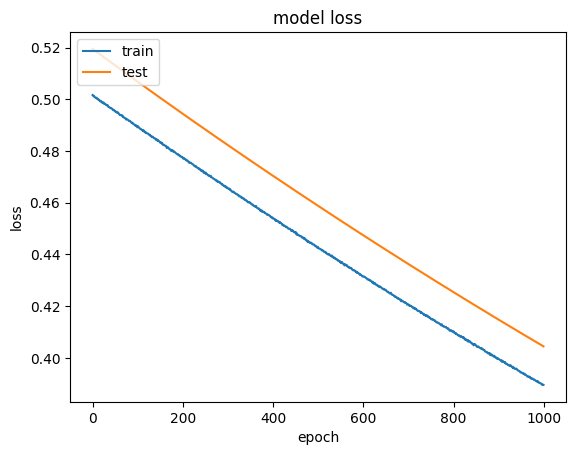

0
count  13245.000000
mean      -0.766534
std       16.708954
min     -301.064052
25%      -12.885423
50%       -2.029176
75%       10.466147
max       60.891992

In [ ]:
print("Long")
long_predictions = [[pred[1] for pred in hurricanes_pred] for hurricanes_pred in long_predictions_scaled]
long_observations = [[obsrv[1] for obsrv in hurricanes_obsrv] for hurricanes_obsrv in y_long_test_scaled]
ai_errors(long_predictions, long_observations, model_long_history).describe()

Pressure


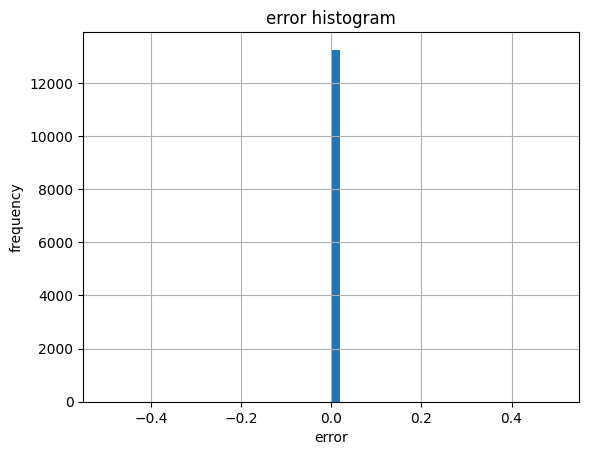

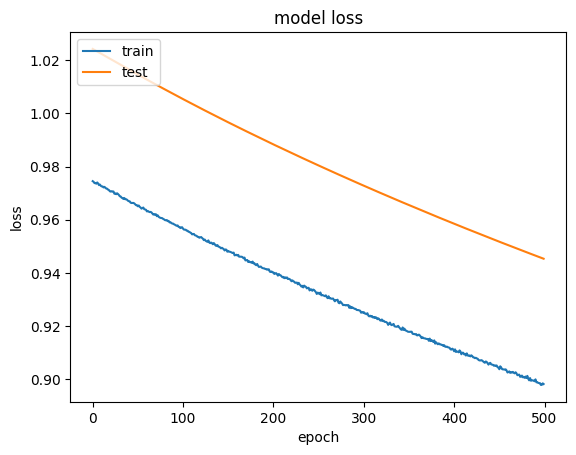

0
count  13245.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0

In [ ]:
print("Pressure")
pressure_predictions = [[pred[0] for pred in hurricanes_pred] for hurricanes_pred in pressure_predictions_scaled]
pressure_observations = [[obsrv[0] for obsrv in hurricanes_obsrv] for hurricanes_obsrv in y_pressure_test_scaled]
ai_errors(pressure_predictions, pressure_observations, model_pressure_history).describe()

In [ ]:
print("Distance")
distance_predictions = [[pred[0] for pred in hurricanes_pred] for hurricanes_pred in distance_predictions_scaled]
distance_observations = [[obsrv[0] for obsrv in hurricanes_obsrv] for hurricanes_obsrv in y_distance_test_scaled]
ai_errors(distance_predictions, distance_observations, model_distance_history).describe()

Distance


NameError: ignored